In [1]:
import os
import json
import numpy as np

from tools.general_utils import work_json, plot_data, create_database
from tools.free_energy_computation import get_mixture_components
from tools.binary_vle import plot_solvation_free_energy_binary, plot_gamma_binary, compute_vapor_mole_fraction, compute_equilibrium_pressure, plot_equilibrium_temperatures

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


# Workflow using solvation free energies to predict VLE for binary mixtures


## Read in initial simulation settings from mixture dataset

In [13]:
## System settings ##

# Define the mixture name
main         = "simulation_systems" # "../master_thesis/Mixtures/" #
mixture      = "mixture_LJ1_LJ2"#"mixture_hexane_butylamine"

# Specify either if mixture at constant pressure or constant temperature (pressures in bar / temperature in K)
system_key   = "90"

# Read in reference dict to get infos about simulation and reference values
ref_dict     = work_json("input_files/mixture_dataset.json")

# Reference values for given mixture
# Liquid mole fraction
x_ref = ref_dict[mixture][system_key]["reference"]["liquid_composition"]
# Vapor mole fraction
y_ref = ref_dict[mixture][system_key]["reference"]["vapor_composition"]
# Equilibrium vapor pressure
p_ref = ref_dict[mixture][system_key]["reference"]["pressure"]
# Equilibrium tempeature
t_ref = ref_dict[mixture][system_key]["reference"]["temperature"]


## Specification for post processing ##

# P-x or T-x diagram
p_x             = True

# Show detailed information from free energy computation 
show            = True

# Free energy method
free_eng_method    = "TI"
free_eng_sub_style = "2d" #"2d_gpr"#"multi_fidelity"#
integration_method = "cubicspline"

# Liquid compositions for which the solvation free energy results, as well as the densities and temperatures should be evaluated at. 
# (in case of densities and temperatures, interpolation is used. In case of solvation free energy, either 2d multifidelity or a polynomial fit of third degree is used.)
x_pred          = np.round( np.linspace(0,1,21), 2 ) #np.array( [ 1.0 ] )

# Fraction of simulation output that should be ommited
fraction        = 0.0

# Specifications for thermodynamic integration path
delta           = 0.0001
both_ways       = True

# Main path where the simulated systems are. They need to have the following sub structure: 
# {component}_coupled/x{composition}/{free_eng_portion}/{free_eng_method}/sim_{i}/fep{i}{i+1}.sampling
main_path       = f"{main}/{mixture}/{system_key}"

# Create results folder
results_path = f"{main_path}/results"
os.makedirs( results_path, exist_ok=True )

# Paths for resulting plots and json files
dG_save_path    = f"{results_path}/%s_solvation_free_energy.png"
gamma_save_path = f"{results_path}/gamma_x.png"
y1_save_path    = f"{results_path}/y_x.png"
p_save_path     = f"{results_path}/p_x.png"
t_save_path     = f"{results_path}/T_x.png"
json_save_path  = f"{results_path}/free_eng_pp_results.json"

# Low fidelity model that should be used
multifidelity_settings_dict = { "lf_databanks": [ "input_files/multifidelity/lf_vdw_data_mix.json", "input_files/multifidelity/lf_coul_data_mix.json" ],
                                "lf_mixtures": [ "mie1_mie2", "ethanol_water" ],
                                "lf_unique_keys": [ "100_0", "1" ],
                                "lf_components": [ [ "mie1", "mie2" ], [ "ethanol", "water" ] ],
                                "lengthscales": [ [ 0.2, 5.0 ], [ 0.3, 3.0 ] ],
                                "fix_lengthscale": False,
                                "fix_hf_noise": True }

## Analyse the binary mixture and save the results


Insertion of LJ1


Acquire data for vdw contribution

Collect simulation data for composition: 0.0
Collect simulation data for composition: 0.1
Collect simulation data for composition: 0.2
Collect simulation data for composition: 0.3
Collect simulation data for composition: 0.4
Collect simulation data for composition: 0.5
Collect simulation data for composition: 0.6
Collect simulation data for composition: 0.7
Collect simulation data for composition: 0.8
Collect simulation data for composition: 0.9
Collect simulation data for composition: 1.0


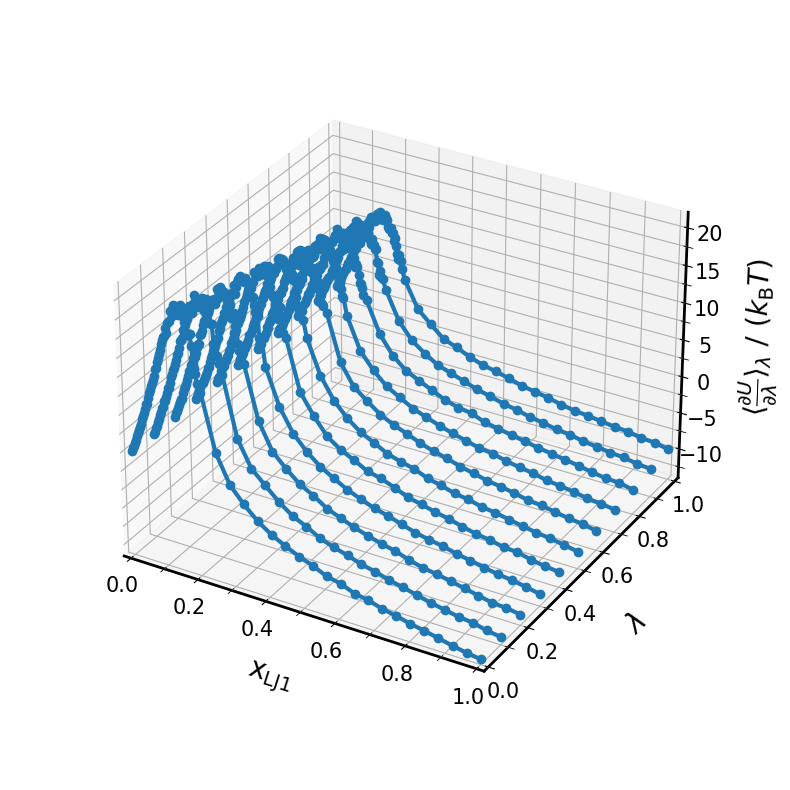


Insertion of LJ2


Acquire data for vdw contribution

Collect simulation data for composition: 0.0
Collect simulation data for composition: 0.1
Collect simulation data for composition: 0.2
Collect simulation data for composition: 0.3
Collect simulation data for composition: 0.4
Collect simulation data for composition: 0.5
Collect simulation data for composition: 0.6
Collect simulation data for composition: 0.7
Collect simulation data for composition: 0.8
Collect simulation data for composition: 0.9
Collect simulation data for composition: 1.0


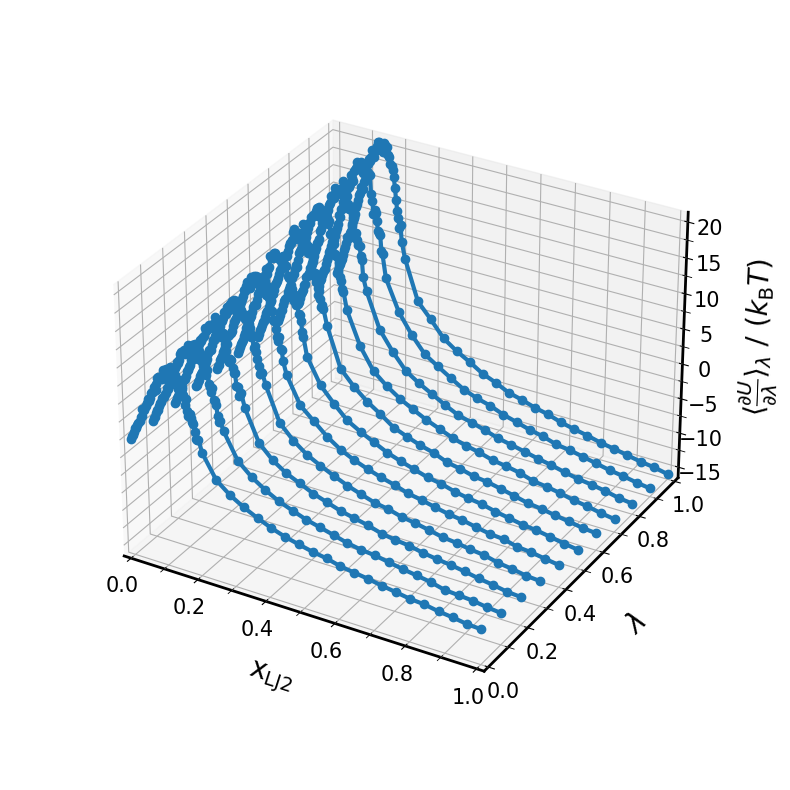

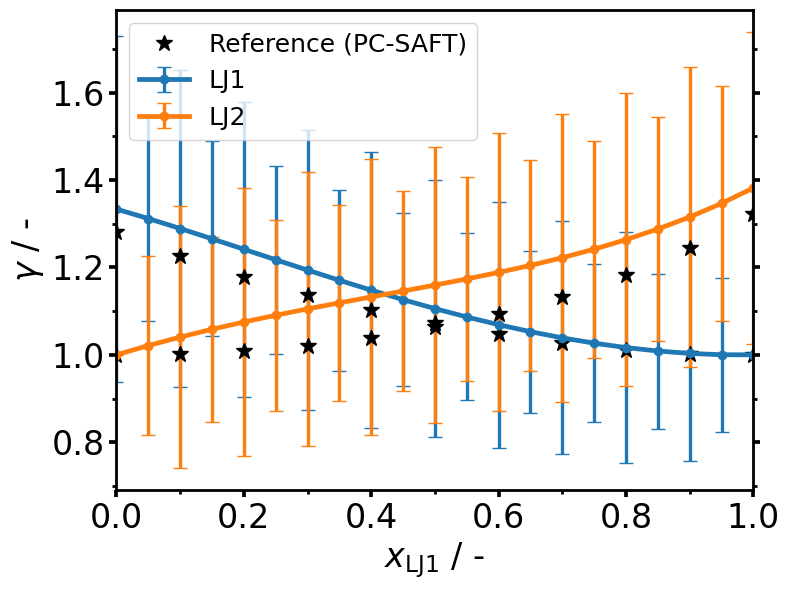

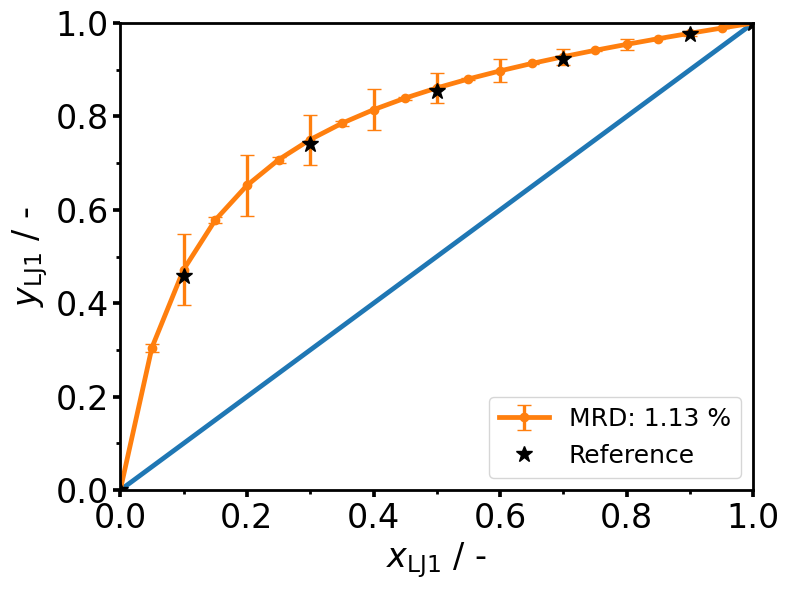

Computing the system pressure with: p = p_{i} + p_{j} and p_{i} = R T \rho_{i+j} * x_{i} * exp( delta G_i^{solv,i+j} / ( RT ) )



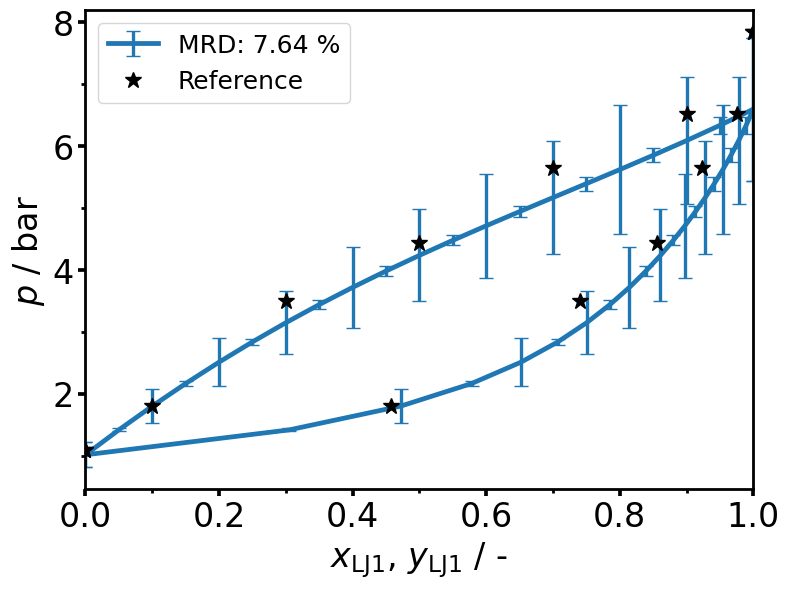

In [14]:
# Acquire the simulation data in form of mixture component objects
settings_dict = { "molecule_name_list": ref_dict[mixture]["general_information"]["molecule_names_list"], 
                  "coupling_lambdas": ref_dict[mixture][system_key]["free_energy"][free_eng_method]["lambdas_coupling"],
                  "main_path": main_path, "Mol_masses": ref_dict[mixture]["general_information"]["molecule_weights_list"], "x_pred": x_pred, "delta": delta, 
                  "both_ways": both_ways, "free_eng_method": free_eng_method, "free_eng_sub_style": free_eng_sub_style, "integration_method": integration_method,
                  "thermodynamic_settings_dict": ref_dict[mixture][system_key]["thermodynamic_settings"], "multifidelity_settings_dict": multifidelity_settings_dict, "verbose": show}

mixture_components = get_mixture_components( **settings_dict )

# Plot the solvation free energy contributions
plot_solvation_free_energy_binary( *mixture_components, save_path = dG_save_path )

# Compute the activity coefficients and the pure vapor pressure for each mixture component
for mixture_component in mixture_components: 
    mixture_component.compute_gamma()
    mixture_component.compute_vapor_pressure()

# Plot the activity coefficients and its saved reference values 
plot_gamma_binary( *mixture_components, save_path = gamma_save_path)

# Compute the vapor mole fractions and seperation factor for each mixture component
compute_vapor_mole_fraction( *mixture_components, save_path = y1_save_path, x_ref = np.array(x_ref), y_ref = np.array(y_ref) )

# Compute the equilibrium pressure and plot the p-x diagramm (if T = const.) or only plot the T-x diagramm (if p = const.) of the mixture
if p_x:
    compute_equilibrium_pressure( *mixture_components, save_path = p_save_path, computation_method = 2,
                                  x_ref = np.array(x_ref), y_ref = np.array(y_ref), p_ref = np.array(p_ref) )
else:
    plot_equilibrium_temperatures( *mixture_components, save_path = t_save_path,
                                   x_ref = np.array(x_ref), y_ref = np.array(y_ref), t_ref = np.array(t_ref) )
    

# Dump the mixture components as json.
results = { mix_comp.component: mix_comp.model_dump() for mix_comp in mixture_components }

work_json( json_save_path, results, to_do="write" ) 

## Add mixture to multi fidelity databank

In [12]:
lf_vdw_database     = "input_files/multifidelity/lf_vdw_data.json"
create_database( mixture_components, key = "vdw", json_save_path = lf_vdw_database )

lf_coulomb_database = "input_files/multifidelity/lf_coulomb_data.json"
create_database( mixture_components, key = "coulomb", json_save_path = lf_coulomb_database )

In [ ]:
# Plot gcmc reference data --> overwork after model dump

with open(f"{results_path}/hr_results.json") as f_mc: hr_data = json.load(f_mc)

with open(json_save_path) as f_fe: fe_data = json.load(f_fe)

component1  = list(fe_data.keys())[0]
x1          = fe_data[component1]["liquid_composition"]
y1          = fe_data[component1]["vapor_composition"]
y1_std      = fe_data[component1]["vapor_composition_std"]
p_equib     = np.array( fe_data[component1]["equilibrium_pressure"] ) / 1e5
p_equib_std = np.array( fe_data[component1]["equilibrium_pressure_std"] ) / 1e5

## y-x ##
data   = [ [x1,x1], [x1,y1,None,y1_std], [hr_data["liquid"],hr_data["vapor"]], [x_ref,y_ref] ]

labels = [ "", "Free solvation energy results", "GCMC results", "Reference" , "$x_\mathrm{%s}$ / -"%component1, "$y_\mathrm{%s}$ / -"%component1 ]

colors = [ "tab:blue", "tab:orange", "tab:gray", "black" ]
ls     = [ "solid", "solid", "dashed", "None"]
marker = [ "None", "None", "None", "*" ]

save_path = f"{results_path}/y_x_w_GCMC.png"

plot_data(data,labels,colors,save_path,ax_lim=[[0.0,1.0],[0.0,1.0]],linestyle=ls,markerstyle=marker)

## P-x ##

data   = [ [x1,p_equib,None,p_equib_std], 
           [y1,p_equib,None,p_equib_std],
           [hr_data["liquid"],hr_data["pressure"]],
           [hr_data["vapor"],hr_data["pressure"]], 
           [x_ref,p_ref], [y_ref,p_ref],
            ]

labels = [ "Free solvation energy results", "", "GCMC results", "", "Reference", "","$x_\mathrm{%s}$, $y_\mathrm{%s}$ / -"%(component1,component1), "$p$ / bar" ]
colors = [ "tab:blue", "tab:blue", "tab:gray", "tab:gray", "black", "black" ]
ls     = [ "solid", "solid", "dashed", "dashed", "None", "None"]
marker = [ "None", "None", "None", "None", "*", "*" ]

save_path = f"{results_path}/p_x_w_GCMC.png"

plot_data(data,labels,colors,save_path,ax_lim=[[0.0,1.0]],linestyle=ls,markerstyle=marker)

NameError: name 'results_path' is not defined